<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 4

In this session, we will focus on how to uncover long timescale properties of complex dynamical systems from partial observations

Before we start, load the following python packages:

In [ ]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [ ]:

import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [ ]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

# Extending to partial observations

Here, we return to the canonical Lorenz system,

$$
\begin{cases}
\dot{x} = \sigma (y - x), \\
\dot{y} = x(\rho - z) - y, \\
\dot{z} = xy - \beta z,
\end{cases}
$$

with $\rho=28$, $\sigma=10$ and $\beta = 8/3$, but instead of working with the full state space, we will try to recover the long timescale properties but working only withe $x$ variable. This emulates most real world scenarios, for which not only do we not know the functional form of the equations of motion, but we might not even have access to the full state space.

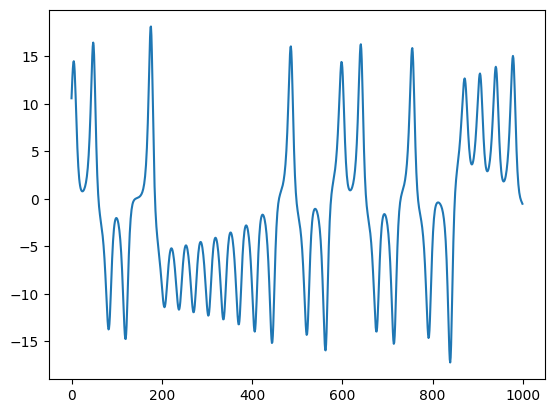

In [ ]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.02
frameRate=1/dt
T = 2500
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]
X = tseries[:,0].reshape(-1,1)
plt.plot(X[:1000])
plt.show()

Now, as you've seen in the tutorial from Greg Stephens, we can reconstruct a topologically equivalent state space through including time delays. Here, we will examine an information theoretic way of thinking about reconstructing a state space by maximizing predictability.

In [ ]:
from scipy.sparse import diags
npartition_range=np.array(np.logspace(2,3,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(1,12,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(npartition_range)))
Ipred_K=np.zeros((len(range_Ks),len(npartition_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K-1)
    print('created trajectory matrix of shape {}'.format(traj_matrix.shape))
    for kn,N in enumerate(npartition_range):
        labels=cl.kmeans_partition(traj_matrix,N,batchsize=5000)
        #estimate entropy rate
        P = op_calc.transition_matrix(labels,1)
        probs = op_calc.stationary_distribution(P)
        logP = P.copy()
        logP.data = np.log(logP.data)
        h = (-diags(probs).dot(P.multiply(logP))).sum()
        H = (-probs*np.log(probs)).sum()
        Ipred = H-h
        h_K[k,kn]=h
        Ipred_K[k,kn] = Ipred
        print('Computed for {} delays and {} partitions.'.format(K,N))

created trajectory matrix of shape (125000, 1)
Computed for 1 delays and 100 partitions.
Computed for 1 delays and 215 partitions.
Computed for 1 delays and 464 partitions.
Computed for 1 delays and 1000 partitions.
created trajectory matrix of shape (125000, 2)
Computed for 2 delays and 100 partitions.
Computed for 2 delays and 215 partitions.
Computed for 2 delays and 464 partitions.
Computed for 2 delays and 1000 partitions.
created trajectory matrix of shape (125000, 3)
Computed for 3 delays and 100 partitions.
Computed for 3 delays and 215 partitions.
Computed for 3 delays and 464 partitions.
Computed for 3 delays and 1000 partitions.
created trajectory matrix of shape (125000, 4)
Computed for 4 delays and 100 partitions.
Computed for 4 delays and 215 partitions.
Computed for 4 delays and 464 partitions.
Computed for 4 delays and 1000 partitions.
created trajectory matrix of shape (125000, 5)
Computed for 5 delays and 100 partitions.
Computed for 5 delays and 215 partitions.
Compu

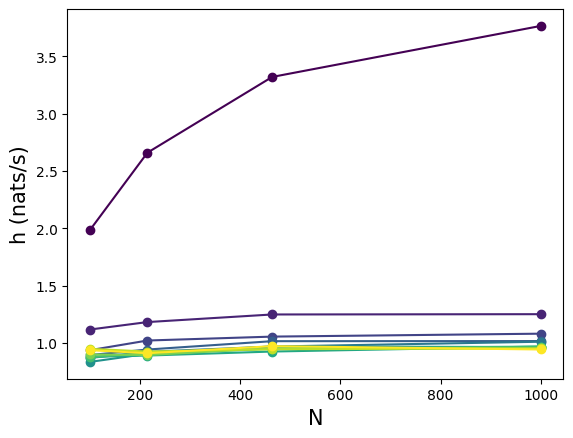

In [ ]:
colors_K = plt.cm.viridis(np.linspace(0,1,len(range_Ks)))
for k,K in enumerate(range_Ks):
    plt.plot(npartition_range,h_K[k],c=colors_K[k],marker='o')
plt.xlabel('N',fontsize=15)
plt.ylabel('h (nats/s)',fontsize=15)
plt.show()

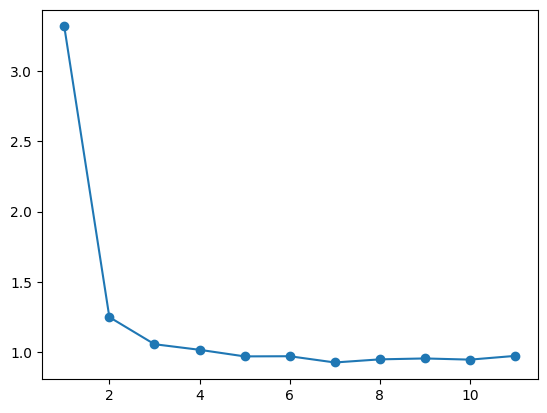

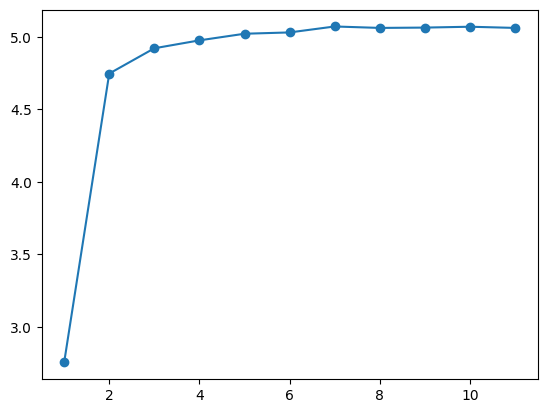

In [ ]:
plt.plot(range_Ks,h_K[:,-2],marker='o')
plt.show()

plt.plot(range_Ks,Ipred_K[:,-2],marker='o')
plt.show()

In [ ]:
K_star=10
traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K_star-1)

In [ ]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(traj_matrix,N,batchsize=50000,return_centers=True)

In [ ]:
delay_range = np.unique(np.array(np.logspace(0,2,100),dtype=int))
n_modes=5
eigvals_delay = np.zeros((len(delay_range),n_modes))
tscales_delay = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  R = op_calc.get_reversible_transition_matrix(P_emp)
  eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=n_modes+1)
  timps=-delay*dt/np.log(eigvals_emp[1:].real)
  tscales_delay[kd] = timps
  eigvals_delay[kd] = eigvals_emp[1:].real
  print(delay)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
31
32
34
35
37
39
41
43
45
47
49
52
54
57
59
62
65
68
72
75
79
83
86
91
95
100


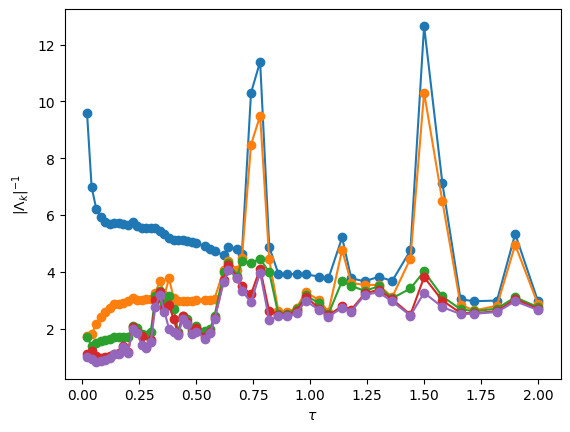

In [ ]:
plt.plot(delay_range*dt,tscales_delay,marker='o')
plt.ylabel(r'$|\Lambda_k|^{-1}$')
plt.xlabel(r'$\tau$')
plt.show()

In [ ]:
delay=10
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]

In [ ]:
phi2_traj = phi2_emp[labels_all]

In [ ]:
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)

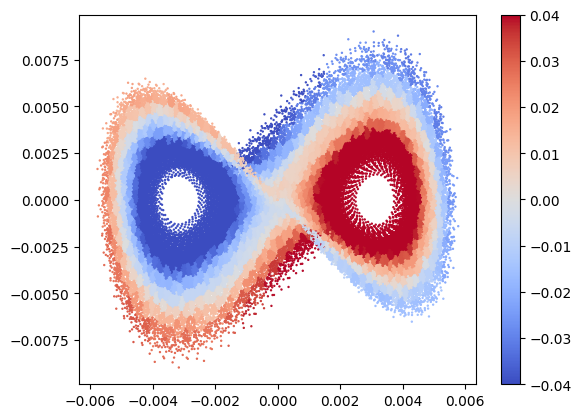

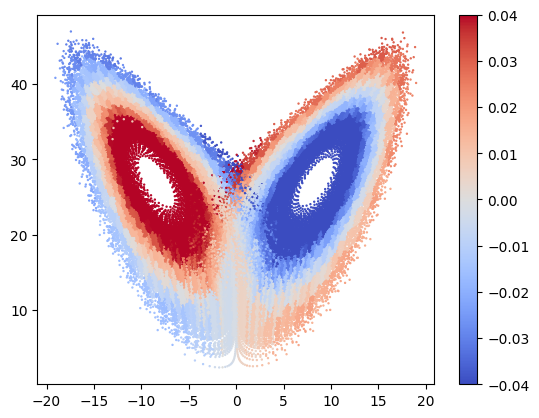

In [ ]:
color_abs = np.max(np.abs(phi2_emp))
plt.scatter(u[:,0],u[:,1],c=phi2_traj,cmap='coolwarm',s=0.5,vmin=-.04,vmax=.04)
plt.colorbar()
plt.show()

color_abs = np.max(np.abs(phi2_emp))
plt.scatter(tseries[:,0],tseries[:,2],c=phi2_traj,cmap='coolwarm',s=0.5,vmin=-.04,vmax=.04)
plt.colorbar()
plt.show()

In [ ]:
from scipy.signal import find_peaks

eps = .3
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(tseries)-1000,100000):
    dist = 1/(np.linalg.norm(tseries[t_idx+1:t_idx+500]-tseries[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])



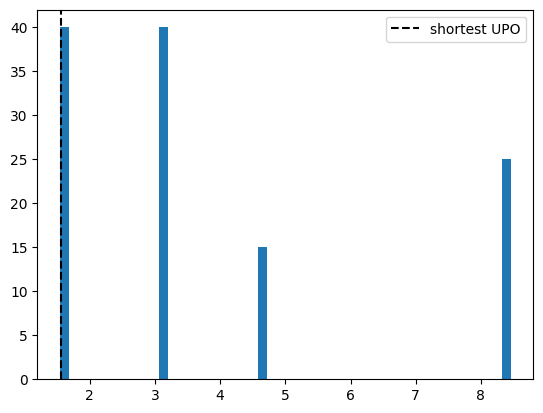

In [ ]:
T_UPO_ref = 1.5586522107161747275678702092126960705284
plt.hist(np.hstack(wsizes)*dt,bins=50)
# plt.xlim(0,5)
plt.axvline(T_UPO_ref,c='k',ls='--',label='shortest UPO')
plt.legend()
plt.show()

In [ ]:
t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
print((tf-t0)*dt)

1.54


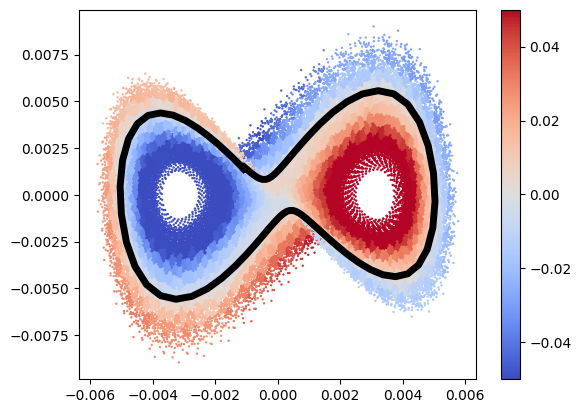

In [ ]:
plt.plot(u[t0:tf+2,0],u[t0:tf+2,1],c='k',lw=5)
plt.scatter(u[:,0],u[:,1],c=phi2_traj,cmap='coolwarm',s=0.5,vmin=-.05,vmax=.05)
plt.colorbar()
plt.show()

As you can see, we find an analogous to the metastable states of equilibrium systems but here for a dissipative chaotic system for which the slow modes are aligned to transitions across a complex higher order fixed point.

In [ ]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

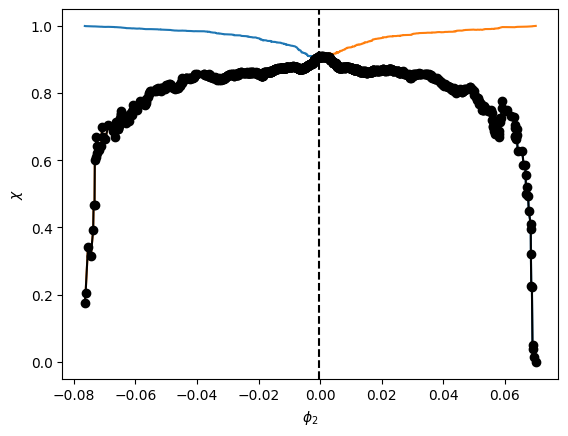

In [ ]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

In [ ]:
distorted_phis,_ = cgm.get_distorted_eigfs(P_emp,2,tau=delay,dt=dt,commute=False)

1
2


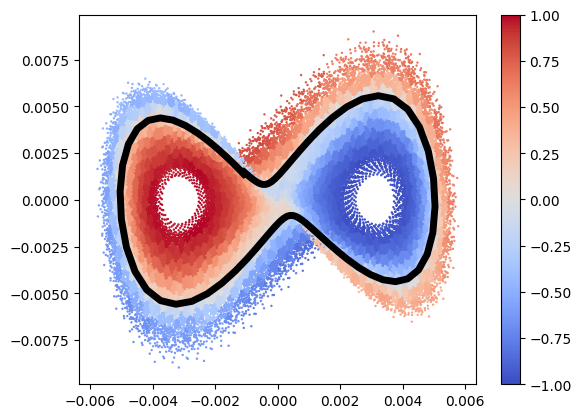

In [ ]:
plt.plot(u[t0:tf+2,0],u[t0:tf+2,1],c='k',lw=5)
plt.scatter(u[:,0],u[:,1],c=distorted_phis[labels_all,0],cmap='coolwarm',s=0.5)
plt.colorbar()
plt.show()

So we find a slow mode that captures the transitions among almost invariant sets

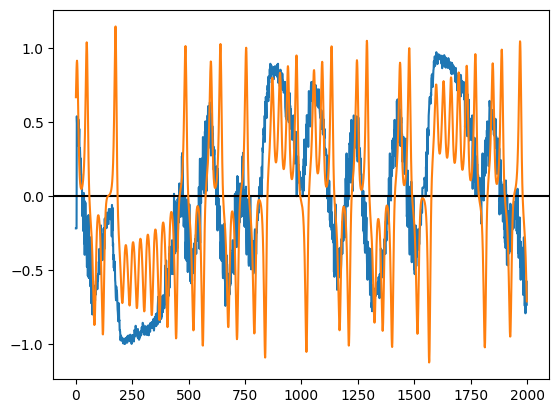

In [ ]:
plt.plot(distorted_phis[labels_all,0][:2000])
plt.axhline(0,c='k')
plt.plot(X[:2000,0]/(2*X[:,0].std()))
plt.show()